Isolation Forest algorithm works for both univariate and multivariate datasets, and uses unsupervised learning

This algo is ideal for detecting anomalies when you have multiple input features because of its ability to handle multivariate data. However, we are mostly using univariate data (just our univariate timeseries metrics), but we also exercise the multivariate capabilities when we perform Principle Component Analysis on the whole dataset to see when the repo as a whole is in an anomolous state.

In our case, our input features will be various different metrics provided by our own api.

The goal of this algo is to determine when a particular metric or the whole repo is in an anomalous state. This could mean, for example, that we are detecting a spike in issues opened.

BELOW IS EXTRA INFO THAT EXPLAINS MORE ABOUT THE ALGORITHM IF YOU ARE INTERESTED:

It works similar to Decision trees algorithm, where we start with a root node and keep on partitioning the space. In Isolation forest we partition randomly, unlike Decision trees where the partition is based on information gain.

Partitions are created by randomly selecting a feature and then randomly creating a split value between the maximum and the minimum value of the feature. We keep on creating the partitions until we isolate all the points(in most cases we also set a limit on number of partitions/height of the tree). The anomaly will be detected in smaller number of partitions than a normal point

So clearly the path length indicates whether a point is a normal or an anomalous point. (Path length - of a point x is measured by the number of edges x traverses an Isolation tree from the root node until the traversal is terminated at an external node)

Isolation forest is an ensemble method. So we create multiple Isolation trees(generally 100 trees will suffice) and we take the average of all the path lengths. This average path length will then decide whether a point is anomalous or not.

In [103]:
import pandas as pd
import requests

# Declare method for collecting data
def collect_data():
    # this part will be in config or provided by broker in implementation
    training_days = 365
    repo_id = 25204
    
    # Declare the endpoints we want to discover insights for
    endpoints = [{'issues-new': 'issues'}, {'code-changes': 'commit_count'}, {'code-changes-lines': 'added'}, {'reviews': 'pull_requests'}]
    base_url = 'http://localhost:5002/api/unstable/repo-groups/9999/repos/{}/'.format(repo_id)
    
    # Dataframe to hold all endpoint results
    # Subtract configurable amount of time
    begin_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
#   begin_date = begin_date.strftime('%Y-%m-%d')
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index=index)#, columns=[key for d in endpoints for key in d.keys()])
    
    # Hit and discover insights for every endpoint we care about
    for metric_meta in endpoints:
        for endpoint, field in metric_meta.items():
            # Hit endpoint
            url = base_url + endpoint
            print("Hitting endpoint: " + url + "\n")
            data = requests.get(url=url).json()

            if len(data) == 0:
                print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
                continue

            if 'date' not in data[0]:
                print("Endpoint {} is not a timeseries, moving to next endpoint.".format(endpoint))
                continue
            
            metric_df = pd.DataFrame.from_records(data)
            metric_df.index = pd.to_datetime(metric_df['date'], utc=True).dt.date
#             print(metric_df)
#             df.add(metric_df[field])
#             df = pd.concat(df, metric_df[field])
            df = df.join(metric_df[field]).fillna(0)
#             print(df)
        
    return df
df = collect_data()
df

Hitting endpoint: http://localhost:5002/api/unstable/repo-groups/9999/repos/25204/issues-new

Hitting endpoint: http://localhost:5002/api/unstable/repo-groups/9999/repos/25204/code-changes

Hitting endpoint: http://localhost:5002/api/unstable/repo-groups/9999/repos/25204/code-changes-lines

Hitting endpoint: http://localhost:5002/api/unstable/repo-groups/9999/repos/25204/reviews



,issues,commit_count,added,pull_requests
2018-12-18,0.0,0.0,0.0,0.0
2018-12-19,2.0,0.0,0.0,0.0
2018-12-20,1.0,0.0,0.0,0.0
2018-12-21,1.0,0.0,0.0,0.0
2018-12-22,0.0,0.0,0.0,0.0
2018-12-23,1.0,0.0,0.0,1.0
2018-12-24,0.0,0.0,0.0,0.0
2018-12-25,0.0,0.0,0.0,0.0
2018-12-26,2.0,1.0,18.0,0.0
2018-12-27,1.0,0.0,0.0,0.0


Visualize all our metrics before doing anomaly detection

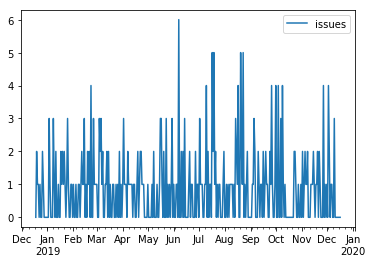

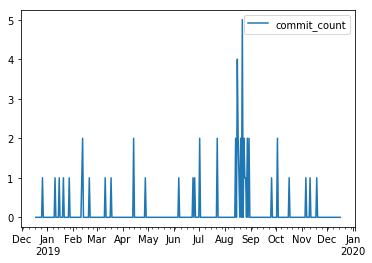

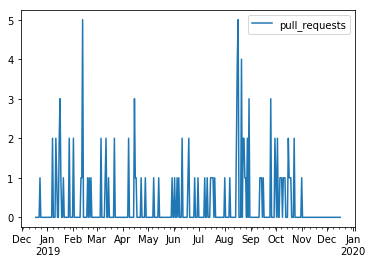

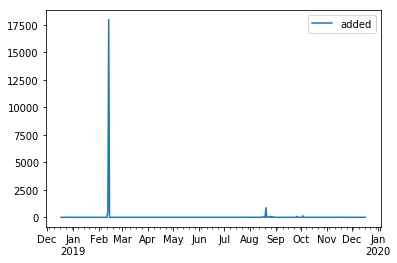

In [104]:
df.plot(y=['issues'], kind='line')
df.plot(y=['commit_count'], kind='line')
df.plot(y=['pull_requests'], kind='line')
df.plot(y=['added'], kind='line')

Isolation forest tries to separate each point in the data. In case of 2D data it randomly creates a line and tries to single out a point. Here an anomalous point could be separated in a few steps while normal points which are closer could take significantly more steps to be segregated.

Contamination is an important parameter here. It is the assumption of the percentage of outlier points in the data. Through testing I found 0.025 to be a fitting value for our use case (which will give us around 10 anomalies / year per metric).

I am using sklearn’s Isolation Forest here as it is a small dataset with 1 year of data, worth noting h2o’s isolation forest is a potentially more scalable possibility on high volume datasets, if the amount of data starts to impact sklearn's performace

In [147]:
from sklearn.ensemble import IsolationForest

# specify the 4 metric names that we will model
to_model_columns = df.columns[1:4]

model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.025), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=32, verbose=0)
model.fit(df[to_model_columns])

IsolationForest(bootstrap=False, contamination=0.025, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=32,
        verbose=0)

In [148]:
import numpy as np
pred = model.predict(df[to_model_columns])
df['anomaly'] = pred
outliers = df.loc[df['anomaly'] == -1]
outlier_index = list(outliers.index)

# Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['anomaly'].value_counts())
boolean_anomalies = df['anomaly'].where(df['anomaly'] == -1, False).where(df['anomaly'] != -1, True).values
boolean_anomalies = boolean_anomalies.astype(np.bool_)

 1    355
-1     10
Name: anomaly, dtype: int64


Now we have 4 metrics on which we have classified anomalies based on isolation forest. We will try to visualize the results and check if the classification makes sense.

We will now normalize and fit the metrics to a PCA to reduce the number of dimensions and then plot them in 3D highlighting the anomalies.

This chart below is very conceptual as it is plotting anomalies for the trading market as a whole, and our "market" is then reduced to 3 defining fields (which do NOT map to any specific symbol, but are rather entirely "new" parameters that define the whole market) which are the parameters that make up the x, y, and x axes.

Anomalies are red X's and normal points are indicated with green points in the plot.

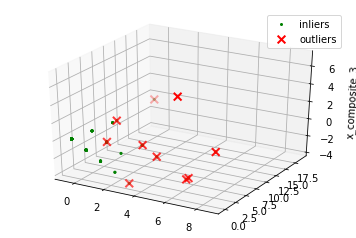

In [149]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

# normalize the metrics
X = scaler.fit_transform(df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3") # Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")# Plot x's for the ground truth outliers
ax.scatter(X_reduce[boolean_anomalies, 0],X_reduce[boolean_anomalies, 1], X_reduce[boolean_anomalies, 2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Now as 2D

Anomalies are highlighted as red edges and normal points are indicated with green points in the plot.

Here the contamination parameter plays a great factor.

Another conceptual chart that helps see anomalies across the whole market as well, but also helps in the parameter-tuning process, specifically for the contamination parameter.

Our idea here is to capture all the anomalous point in the system. So its better to identify few points which might be normal as anomalous (false positives), but not to miss out catching an anomaly (true negative). (So I have specified 12% as contamination which varies based on use case)

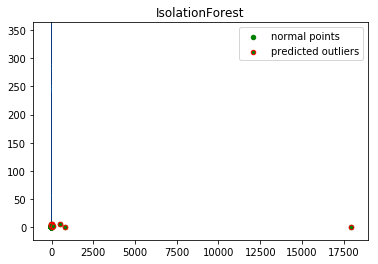

In [150]:
pca = PCA(2)
pca.fit(df[to_model_columns])
res = pd.DataFrame(pca.transform(df[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf(Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green', s=20, label="normal points")
b1 = plt.scatter(res.iloc[boolean_anomalies,0], res.iloc[boolean_anomalies,1], c='green', s=20, edgecolor="red", label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

Now we have figured the anomalous behavior at a use case level, but to be actionable on the anomaly its important to identify and provide information on which symbols are anomalous individually.

The anomalies identified by the algorithm should make sense when viewed visually (sudden dip/peaks) by the business user to act upon it. So creating a good visualization is equally important in this process.

The following function creates actuals plot on a time series with anomaly points highlighted on it. Also a table which provides actual data, the change and conditional formatting based on anomalies.

In [151]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
from matplotlib import pyplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

def plot_anomaly(df,metric_name):
    df.date = pd.to_datetime(df['date_col'].astype(str))#, format="%Y%m%d")
    dates = df.date
    
    # Identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    volume = df["volume"][-len(bool_array):]
    anomaly_points = bool_array * volume
    anomaly_points[anomaly_points == 0] = np.nan
    
    # A dictionary for conditional format table based on anomaly
    color_map = {0: "rgba(228, 222, 249, 0.65)", 1: "yellow", 2: "red"} #rgba(228, 222, 249, 0.65)
    
    # Table which includes Date, Actuals, Change occured from previous point
    table = go.Table(
        domain = dict(x = [0, 1], y = [0, 0.3]),
        columnwidth = [1, 2],
        # columnorder=[0, 1, 2,],
        header = dict(
            height=20,
            values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],],
            font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
            fill=dict(color='#d562be')
        ),
        cells = dict(
            values = [df.round(3)[k].tolist() for k in ['date_col', 'volume', 'percentage_change']],
            line = dict(color='#506784'),
            align = ['center'] * 5,
            font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
            # format = [None] + [",.4f"] + [',.4f'],
            # suffix = [None] * 4,
            suffix = [None] + [''] + [''] + ['%'] + [''],
            height = 27,
            fill = dict(color = [test_df['anomaly_class'].map(color_map)],)#map based on anomaly level from dictionary
        )
    )
    
    #Plot the actuals points
    volumes = go.Scatter(
        name = 'Volume',
        x = dates,
        y = df['volume'],
        xaxis = 'x1', 
        yaxis = 'y1',
        mode = 'lines',
        marker = dict(
            size = 12,
            line = dict(width=1),
            color = "blue")
        ) #Highlight the anomaly points
    anomalies_map = go.Scatter(
        name = "Anomaly",
        showlegend = True,
        x = dates,
        y = anomaly_points,
        mode = 'markers',
        xaxis = 'x1',
        yaxis = 'y1',
        marker = dict(
            color = "red",
            size = 11,
            line = dict(
                color = "red",
                width = 2)
            )
        )
    axis = dict(
        showline = True,
        zeroline = False,
        showgrid = True,
        mirror = True,
        ticklen = 4,
        gridcolor = '#ffffff',
        tickfont = dict(size=10)
    )
    layout = dict(
        width = 1000,
        height = 865,
        autosize = False,
        title = metric_name,
        margin = dict(t = 75),
        showlegend = True,
        xaxis1 = dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1 = dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f'))
    )
    fig = go.Figure(data=[table, anomalies_map, volumes], layout=layout)
    iplot(fig)
pyplot.show()

A helper function to find percentage change,classify anomaly based on severity.

The predict function classifies the data as anomalies based on the results from decision function on crossing a threshold. Say if the business needs to find the next level of anomalies which might have an impact, this could be used to identify those points.

The top 12 quantiles are identified anomalies(high severity), based on decision function here we identify the 12–24 quantile points and classify them as low severity anomalies.

In [152]:
def classify_anomalies(df,metric_name):
    df['metric_name'] = metric_name
    df = df.sort_values(by='date_col', ascending=False)
    
    # Shift metric values by one date to find the percentage chage between current and previous data point
    df['shift'] = df['volume'].shift(-1)
    df['percentage_change'] = ((df['volume'] - df['shift']) / df['volume']) * 100
    
    # Categorise anomalies as 0 - no anomaly, 1 - low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

Identify anomalies for individual metrics and plot the results.

X axis — date Y axis — Metric values and anomaly points.

The plots allow us to see the sudden spikes and dips in the volume and project the anomalous points onto the plot.

The tables below each plot allow us to examine the raw data and see potential holes or broken pipelines in the data that would need to be fixed in our preprocessing steps. They also let us see which anomalies are low-level (yellow) or high level (red)

In [153]:
import warnings  
warnings.filterwarnings('ignore')
for i in range(1,len(df.columns)-1):
    model.fit(df.iloc[:,i:i+1])
    pred = model.predict(df.iloc[:,i:i+1])
    test_df = pd.DataFrame()
    
    test_df['date_col'] = df.index#df['date']
    test_df.index = df.index
    
    # Find decision function to find the score and classify anomalies
    test_df['score'] = model.decision_function(df.iloc[:,i:i+1])
    test_df['volume'] = df.iloc[:,i:i+1]
    test_df['anomaly'] = pred

    # Get the indexes of outliers in order to compare the metrics with use case anomalies if required
    outliers = test_df.loc[test_df['anomaly'] == -1]
    outlier_index = list(outliers.index)
    test_df = classify_anomalies(test_df,df.columns[i])
    plot_anomaly(test_df,df.columns[i])